**Author:** Kamer Cekini

**Course:** Artificial Intelligence Fundamental 2023/2024 (Unipi)

**Github:** https://github.com/KamerC1/AIF

# Introduzione

Il progetto si basa sul videogioco rogue-like NetHack. Questo videogioco è particolarmente interessante dal punto di vista dell'intelligenza artificiale per la sua complessità, vastità e la presenza di strumenti che permettono di interagire facilmente con il gioco attraverso linguaggi di programmazione come Python. L'obiettivo del nostro agente è raccogliere tutte le monete (o qualsiasi altro oggetto raccoglibile) all'interno di un dungeon, minimizzando il più possibile il numero di passi necessari. L'ambiente di gioco è completamente osservabile, consentendo all'agente di conoscere la disposizione della mappa, inclusi ostacoli e monete. Inoltre, è deterministico, episodico, statico, discreto e con un unico agente coinvolta nell'interazione.

In questo notebook abbiamo posto il vincolo che, una volta raccolte tutte le monete, l'agente deve tornare alla posizione di partenza -  In altre parole, si tratta del problema del commesso viaggiatore (TSP). Questo vincolo rende più semplice valutare l'algoritmo genetico, poiché esistono algoritmi noti per risolvere il TSP con esattezza. Tuttavia, come vedremo nella sezione dedicata alla funzione di fitness, è possibile modificare questo vincolo con facilità.

Il TSP è un problema NP-difficile, il che significa che non esiste un algoritmo noto che possa risolverlo in tempo polinomiale. Per questo motivo, si ricorre spesso a algoritmi euristici per ottenere soluzioni che si avvicinino alla soluzione ottimale. D'altra parte, esistono anche algoritmi che possono restituire soluzioni esatte, come l'algoritmo di Held-Karp, che ha una complessità spaziale di $O(n \cdot 2^n)$  e una complessità temporale di $O(n^2 \cdot 2^n)$, dove $n$ rappresenta il numero di monete.

Noi affronteremo questo problema utilizzando un algoritmo genetico, che offre una soluzione non ottimale ma approssimata, con un costo computazionale più contenuto rispetto alle soluzioni esatte.

# Methodologies

In [9]:
import gym
import nle
import sys
import time
from IPython.display import clear_output

sys.path.append('minihack/')
from minihack import LevelGenerator
from nle import nethack

from WorldParser import WorldParser
from GeneticAlgorithm import GeneticAlgorithm
from AgentActions import AgentActions

## Rappresentazione del mondo di gioco

NetHack è un videogioco caratterizzato da una griglia di gioco e da un sistema di gioco a turni. La struttura della mappa è definita attraverso un formato denominato des-file. Per il nostro progetto, ci interessano principalmente i seguenti elementi:

- Il carattere "`.`" rappresenta un terreno attraversabile dall'agente.
- Il carattere " `|` " rappresenta un muro, ovvero una cella non attraversabile.
- La notazione "`GOLD:c,(x,y)`" indica che nella cella di coordinate `(x,y)` sono presenti `c` monete d'oro.

Grazie al file DES, viene estratto un grafo utilizzando la libreria `networkx`, il quale rappresenta la mappa di gioco includendo gli ostacoli. È importante notare che i nodi del grafo sono collegati anche diagonalmente, poiché nell'ambiente di NetHack l'agente può spostarsi in diagonale. Inoltre, viene creata una lista che contiene la posizione dell'oro all'interno della mappa. Il codice che mostra il des-file e la rappresentazione a grafo del mondo di gioco è presente nella seguente cella:

Gold positions:  [(2, 1), (1, 2), (4, 7), (4, 9), (5, 11), (1, 6)]


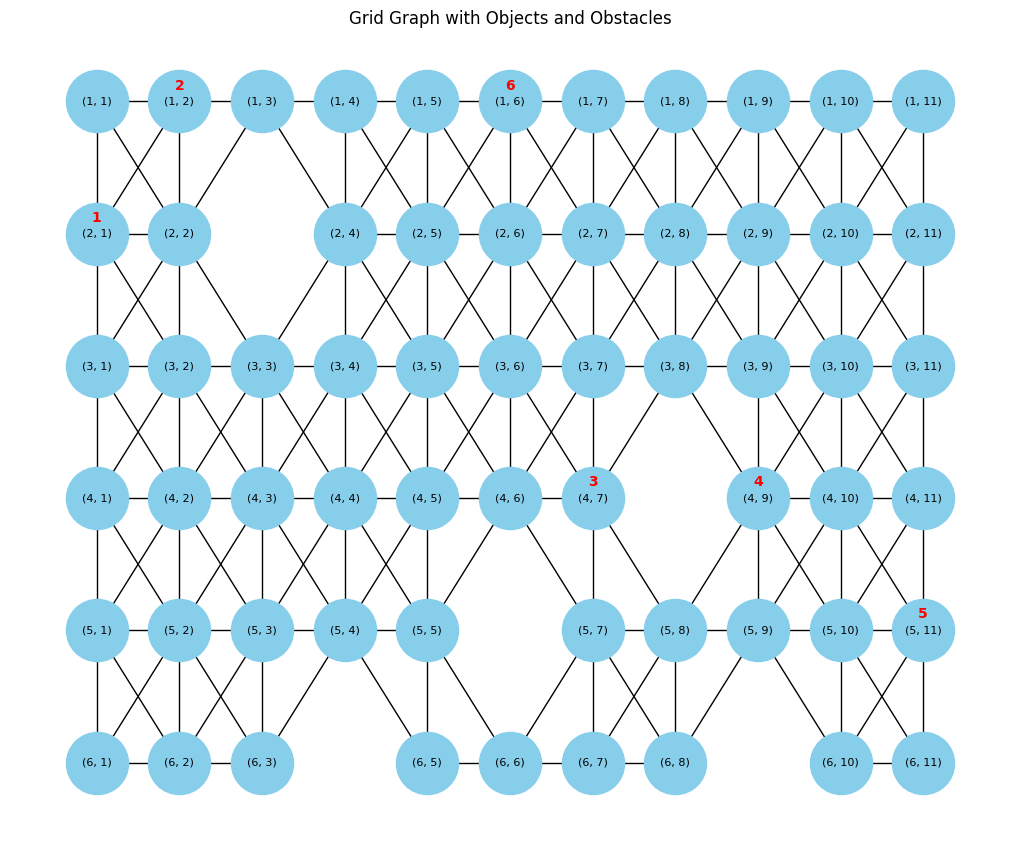

In [10]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center

MAP
|||||||||||||
|...........|
|..|........|
|...........|
|.......|...|
|.....|.....|
|...|....|..|
|||||||||||||
ENDMAP

BRANCH:(1,1,1,1),(0,0,0,0)
GOLD:1,(1,2)
GOLD:1,(2,1)
GOLD:1,(7,4)
GOLD:1,(9,4)
GOLD:1,(11,5)
GOLD:1,(6,1)

"""

starting_position = (1,1)

parser = WorldParser(des_file)
gold_positions = parser.extract_gold_positions()
world_graph = parser.extract_world_graph()

print("Gold positions: ", gold_positions)
parser.plot_world_graph(world_graph, gold_positions)

## Algoritmo genetico

Una volta estratto il grafo del mondo di gioco con la posizione iniziale degli oggetti, l'algoritmo genetico (implementato attraverso la libreria `deap`) opera esclusivamente su questa rappresentazione. In particolare, ciascun genoma rappresenta una permutazione delle posizioni degli oggetti da raccogliere. L'ordine degli oggetti nel genoma determina l'ordine con cui gli oggetti saranno raccolti durante l'esecuzione dell'algoritmo. In particolare, l’obbiettivo dell’algoritmo genetico è di minimizzare la seguente funzione fitness:

$$
fitness(g_1, ...,g_n) = d(s_1, g_1) + \sum_{i=1}^{n-1}d(g_i, g_j) + d(g_n, s_2)
$$

dove:

- $g_1,…,g_n$: rappresentano le posizioni spaziali degli oggetti, costituendo una permutazione delle posizioni dell'oro.
- $s_1$: posizione di partenza dell’agente.
- $s_2$: la posizione finale in cui l'agente deve trovarsi. In questo particolare notebook, come indicato nell'introduzione, $𝑠_1 = 𝑠_2$.
- $d(a, b)$: la distanza del cammino minimo tra la posizione $𝑎$ e la posizione $b$. Data la presenza di ostacoli, il cammino minimo viene calcolato usando l'algoritmo `A*` (con la distanza di Manhattan come euristica).

Riassumendo, l’algoritmo genetico fornisce l’ordine con cui visitare gli oggetti e di ritornare al punto di partenza, cercando di minimizzare il numero di passi. La seguente cella mostra l’ordine sub-ottimale per raccogliere gli oggetti (indicato attraverso un numero rosso sui relativi nodi) e il costo di tale cammino.

/home/kamer/miniconda3/envs/nle/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/kamer/miniconda3/envs/nle/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Starting position: (1, 1)
Miglior percorso: [(1, 2), (1, 6), (4, 9), (5, 11), (4, 7), (2, 1), (1, 1)]
Distanza del miglior percorso: 21


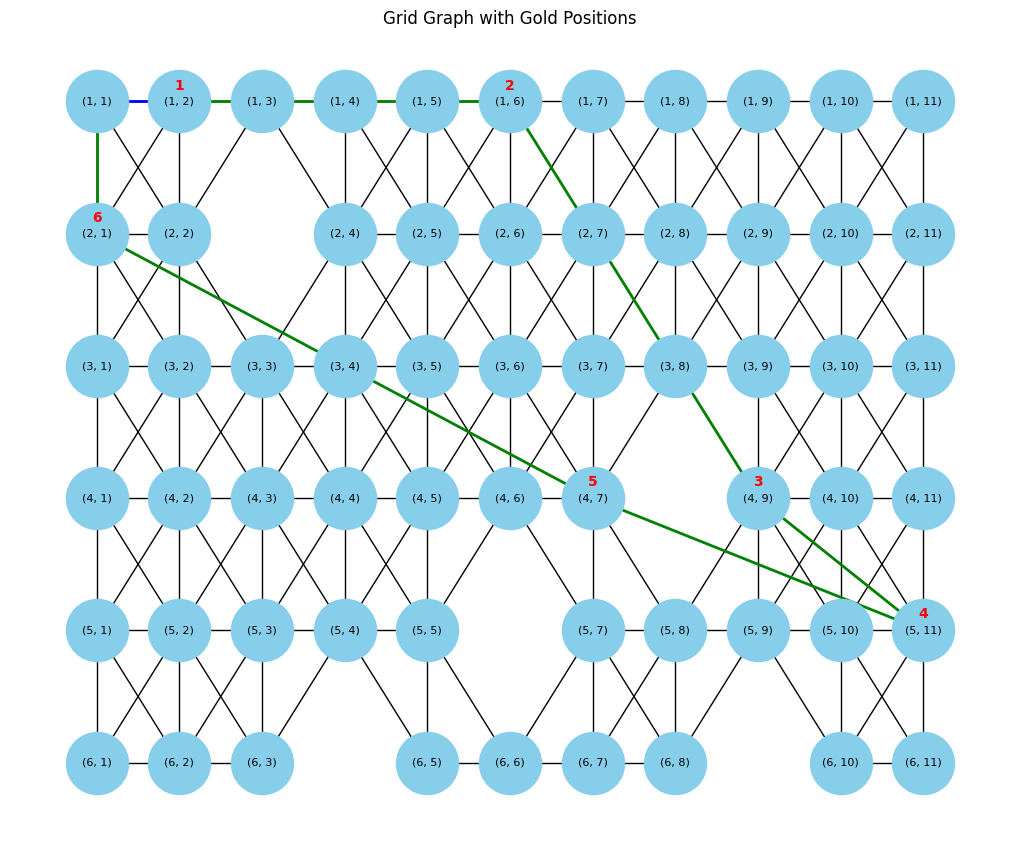

In [11]:
optimizer = GeneticAlgorithm(world_graph, gold_positions, starting_position=starting_position)
best_route, best_distance = optimizer.optimize()
print("Starting position:", optimizer.starting_position)
print("Miglior percorso:", best_route)
print("Distanza del miglior percorso:", best_distance)

optimizer.plot_world_graph(best_route)

## Ricerca del percorso migliore

Tuttavia, l’algoritmo genetico non fornisce le indicazioni all’agente su come raggiungere effettivamente queste posizioni, ma solo l’ordine sub-ottimale con cui raccogliere gli oggetti. Per risolvere questo problema, date due posizione $P_i, P_j$, viene nuovamente applicato $A^*$ per trovare il percorso (i.e. le celle da visitare) per raggiungere la posizione $P_j$ a partire da $P_i$. Ad esempio, se $P_i = (1,2)$ e $P_j = (4,7)$ ⇒ il percorso più breve è:

In [12]:
agentActions = AgentActions(world_graph, starting_position)
shortest_path = agentActions._find_shortest_path((1,2), (4,7))
print(shortest_path)

[(1, 2), (2, 2), (3, 3), (4, 4), (4, 5), (4, 6), (4, 7)]


Questo path viene successivamente convertito in azioni di giochi eseguibili dall’agente. Ad esempio:

In [13]:
actions = agentActions._get_dPad_movement_from_path(shortest_path )
print(agentActions._convert_actions_to_integer(actions))

[2, 5, 5, 1, 1, 1]


Le azioni corrispondono ai seguenti movimenti:

- 0: muoversi verso nord
- 1: muoversi verso est
- 2: muoversi verso sud
- 3: muoversi verso ovest
- 4: muoversi verso nord-est
- 5: muoversi verso sud-est
- 6: muoversi verso sud-ovest
- 7: muoversi verso nord-ovest
- 49: raccogliere gli oggetti

Questo viene fatto per tutti le coppie di posizione: $(s_1, g_1), (g_1, g_2), ..., (g_n, s_2)$, dove:

- $s_1$: rappresenta la posizione iniziale
- $g_i$: rappresenta l’i-esimo oggetto raccogliere
- $s_2$: rappresenta la posizione finale

Tra una coppia di posizioni e l’altra viene aggiunta l’azione di raccolta (collect).

Il seguente codice mostra questo processo:

In [14]:
actions = agentActions.get_agent_actions(best_route)
print(actions)

[1, 49, 1, 1, 1, 1, 49, 5, 5, 5, 49, 5, 1, 49, 7, 3, 7, 6, 49, 7, 7, 3, 7, 6, 3, 49, 0]


## Esecuzioni delle azioni

Una volta ottenuta la lista delle azioni dal passaggio precedente, queste vengono attuate nel mondo di gioco.

In [15]:
env = gym.make("MiniHack-Skill-Custom-v0",
    des_file=des_file)
env.reset()
env.render()
time.sleep(0.5)

for action in actions:
    env.step(action)
    clear_output(wait=True)
    env.render()
    time.sleep(0.5)


                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                -------------                                   
                                |@..........|                                   
                                |..|........|                                   
                                |...........|                                   
                           

# Valutazione

Per valutare l'efficacia dell'algoritmo genetico, sono stati generati casualmente diversi grafi. Ogni grafo ha dimensioni 10x10, contiene 20 ostacoli, 10 celle con oro e posizione iniziale scelta casualmente. Su questi grafi sono stati applicati sia l'algoritmo genetico sia l'algoritmo Held-Karp, noto per restituire la soluzione ottimale, ma con un costo computazionale esponenziale. I risultati dell’algoritmo genetico sono riportati nella tabella seguente:

| Parametri | Media Tasso di crescita | Media Differenza | Mean Time |
| --- | --- | --- | --- |
| $p = 10, g = 10$ | $45.68\% \pm 19.59\%$ | $11.99 \pm 5.05$ | $0.05 s$ |
| $p = 50, g = 10$ | $20.84\% \pm 12.84\%$ | $5.40 \pm 3.10$ | $0.15 s$ |
| $p = 500, g = 10$ | $8.30\% \pm 7.80\%$ | $2.18 \pm 1.99$ | $1.26 s$ |
| $p = 1000, g = 10$ | $5.50\% \pm  5.68\%$ | $1.42 \pm 1.45$ | $2.34 s$ |
| $p = 2000, g = 10$ | $4.51\% \pm  5.43\%$ | $1.19 \pm 1.41$ | $4.84 s$ |
| $p = 10000, g = 10$ | $4.74\% \pm 6\%$ | $1.22 \pm 1.48$ | $23.80 s$ |
| $p =50, g = 50$ | $13.19\% \pm 10\%$ | $3.54 \pm 2.54$ | $0.51 s$ |
| $p =1000, g = 50$ | $5.80\% \pm 6.8\%$ | $1.48 \pm 1.63$ | $12.16 s$ |
| $p = 10, g = 500$ | $18.3\% \pm 10.5\%$ | $4.84 \pm 2.73$ | $0.12 s$ |
| $p = 50, g = 500$ | $11.7\% \pm 9\%$ | $3.14 \pm 2.40$ | $4.11 s$ |
| $p = 500, g = 500$ | $8.85\% \pm 8\%$ | $2.23 \pm  2.03$ | $39.49 s$ |

Dove

- $p$: dimensione della popolazione
- $g$: numero di generazioni
- Il tasso di crescita è calcolato come:
    
    $$
    \text{tasso di crescita} = \frac{\text{differenza}}{distance_o}
    $$
    
    Dove $\text{differenza} = \text{distance}_g - \text{distance}_o$:
    
    - $\text{distance}_g$ : lunghezza del cammino ottenuto dall’algoritmo genetico
    - $\text{distance}_o$ : lunghezza del cammino ottimo ottenuto tramite l'algoritmo Held-Karp
- **Tempo medio**: tempo di esecuzione medio dell'algoritmo genetico

Come evidenziato dalla tabella, l'iperparametro $p$ ha il maggior impatto sulle prestazioni, influenzando sia il tasso di crescita che la differenza. D'altra parte, l'iperparametro $g$ ha un impatto marginale sulle prestazioni, ma incide significativamente sul tempo di esecuzione.

Il codice per la generazione dei grafi e la simulazione dell'algoritmo genetico e dell'algoritmo Held-Karp è disponibile nel notebook `Analysis/performance.ipynb`.

# Conclusione

In conclusione, questo progetto si è dedicato alla risoluzione di un problema ispirato al videogioco rogue-like NetHack mediante l'utilizzo di un algoritmo genetico. L'obiettivo è di raccogliere tutte le monete all'interno di un dungeon minimizzando il numero di passi, con il requisito di tornare alla posizione di partenza una volta completata la raccolta.

L'algoritmo genetico è stato scelto per la sua capacità di fornire soluzioni approssimate efficientemente, considerando la natura NP-difficile del problema del commesso viaggiatore. Questo approccio ha permesso di generare percorsi di raccolta degli oggetti che, pur essendo sub-ottimali, si sono dimostrati adeguati per il contesto del gioco.